# <!-- TITLE --> Sentiment analysis
<!-- DESC --> This notebook is an example of sentiment analysis using a dataset from Internet Movie Database (IMDB).
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text.
 - Understand the management of **textual data** and **sentiment analysis**

It is decomposed in 3 parts:

- **Part 1**: Build a classifier with one-hot encoding
- **Part 2**: Replace one-hot endodings by word embeddings
- **Part 3**: Combine word embedding and a recurrent architecture

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result

Disclaimer: This notebook is based on [fidle-cnrs](https://gricad-gitlab.univ-grenoble-alpes.fr/talks/fidle/-/tree/master)

# Preliminaries: import and init

In [13]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

from sklearn.metrics import confusion_matrix

import os,sys,h5py,json
from importlib import reload

In [14]:
run_dir = os.getcwd()
output_dir='data'

# Part 1: Model based on one-hot encoding

## Step 1 - Parameters

The words in the vocabulary are classified from the most frequent to the rarest.\
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).\
`hide_most_frequently` is the number of ignored words, among the most common ones\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [79]:
vocab_size           = 5000
hide_most_frequently = 0

epochs               = 10
batch_size           = 512
fit_verbosity        = 1

## Step 2 - Understanding hot-one encoding
#### We have a **sentence** and a **dictionary** :

In [80]:
sentence = "I've never seen a movie like this before"

dictionary  = {"a":0, "before":1, "fantastic":2, "i've":3, "is":4, "like":5, "movie":6, "never":7, "seen":8, "this":9}

#### We encode our sentence as a **numerical vector** :

In [81]:
sentence_words = sentence.lower().split()

sentence_vect  = [ dictionary[w] for w in sentence_words ]

print('Words sentence are         : ', sentence_words)
print('Our vectorized sentence is : ', sentence_vect)

Words sentence are         :  ["i've", 'never', 'seen', 'a', 'movie', 'like', 'this', 'before']
Our vectorized sentence is :  [3, 7, 8, 0, 6, 5, 9, 1]


#### Next, we **one-hot** encode our vectorized sentence as a tensor :

In [82]:
# ---- We get a (sentence length x vector size) matrix of zeros
#
onehot = np.zeros( (10,8) )

# ---- We set some 1 for each word
#
for i,w in enumerate(sentence_vect):
    onehot[w,i]=1

# --- Show it
#
print('In a basic way :\n\n', onehot, '\n\nWith a pandas wiew :\n')
data={ f'{sentence_words[i]:.^10}':onehot[:,i] for i,w in enumerate(sentence_vect) }
df=pd.DataFrame(data)
df.index=dictionary.keys()
# --- Pandas Warning
#
df.style.format('{:1.0f}').highlight_max(axis=0).set_properties(**{'text-align': 'center'})

In a basic way :

 [[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]] 

With a pandas wiew :



,...i've...,..never...,...seen...,....a.....,..movie...,...like...,...this...,..before..
a,0,0,0,1,0,0,0,0
before,0,0,0,0,0,0,0,1
fantastic,0,0,0,0,0,0,0,0
i've,1,0,0,0,0,0,0,0
is,0,0,0,0,0,0,0,0
like,0,0,0,0,0,1,0,0
movie,0,0,0,0,1,0,0,0
never,0,1,0,0,0,0,0,0
seen,0,0,1,0,0,0,0,0
this,0,0,0,0,0,0,1,0


### 3.2 - Load dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

By default :
 - Start of a sequence will be marked with : 1
 - Out of vocabulary word will be : 2
 - First index will be : 3

In [83]:
# ----- Retrieve x,y
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently)

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

# ---- About
#
print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


## Step 4 - About our dataset
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

### 4.1 - Sentences encoding

In [84]:
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nOpinions (y_train) :\n\n',y_train)


Review example (x_train[12]) :

 [2, 2, 119, 954, 189, 1554, 2, 2, 459, 2, 2, 116, 2, 1492, 2291, 2, 726, 2, 1939, 168, 2031, 2, 423, 2, 2, 549, 2, 2, 2, 547, 2, 2, 2, 2, 2, 454, 2, 2, 2, 2, 2, 2, 130, 168, 2, 2, 359, 2, 158, 1511, 2, 2, 2, 1913, 2, 194, 4455, 4121, 2, 114, 2, 2, 2, 465, 2, 304, 2, 2, 2, 2, 2, 2, 155, 2, 2, 226, 162, 616, 651, 2, 2, 2, 2, 2, 2, 2, 2, 218, 4843, 629, 2, 3017, 2, 2, 2, 2, 2, 534, 2, 2, 320, 2, 516, 2, 2, 2, 181, 2, 130, 2, 547, 3571, 2, 1471, 851, 2, 2286]

Opinions (y_train) :

 [1. 0. 0. ... 0. 1. 0.]


### 4.2 - Load dictionary

In [85]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and <unknown> tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()}

# ---- About dictionary
#
print('\nDictionary size     : ', len(word_index))
print('\nSmall extract :\n')
for k in range(440,455):print(f'    {k:2d} : {index_word[k]}' )

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])


Dictionary size     :  88588

Small extract :

    440 : hope
    441 : entertaining
    442 : she's
    443 : mr
    444 : overall
    445 : evil
    446 : called
    447 : loved
    448 : based
    449 : oh
    450 : several
    451 : fans
    452 : mother
    453 : drama
    454 : beginning


### 4.3 - Have a look, for human

In [86]:
print(f'Review example : \n{x_train[12]}')

print(f'After translation : \n{dataset2text(x_train[12])}')

Review example : 
[2, 2, 119, 954, 189, 1554, 2, 2, 459, 2, 2, 116, 2, 1492, 2291, 2, 726, 2, 1939, 168, 2031, 2, 423, 2, 2, 549, 2, 2, 2, 547, 2, 2, 2, 2, 2, 454, 2, 2, 2, 2, 2, 2, 130, 168, 2, 2, 359, 2, 158, 1511, 2, 2, 2, 1913, 2, 194, 4455, 4121, 2, 114, 2, 2, 2, 465, 2, 304, 2, 2, 2, 2, 2, 2, 155, 2, 2, 226, 162, 616, 651, 2, 2, 2, 2, 2, 2, 2, 2, 218, 4843, 629, 2, 3017, 2, 2, 2, 2, 2, 534, 2, 2, 320, 2, 516, 2, 2, 2, 181, 2, 130, 2, 547, 3571, 2, 1471, 851, 2, 2286]
After translation : 
<unknown> <unknown> love cheesy horror flicks <unknown> <unknown> care <unknown> <unknown> acting <unknown> sub par <unknown> whether <unknown> monsters look corny <unknown> liked <unknown> <unknown> except <unknown> <unknown> <unknown> feeling <unknown> <unknown> <unknown> <unknown> <unknown> beginning <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> end look <unknown> <unknown> need <unknown> 10 page <unknown> <unknown> <unknown> sign <unknown> big letters explaining <unknown> plot <

### 4.4 - Few statistics

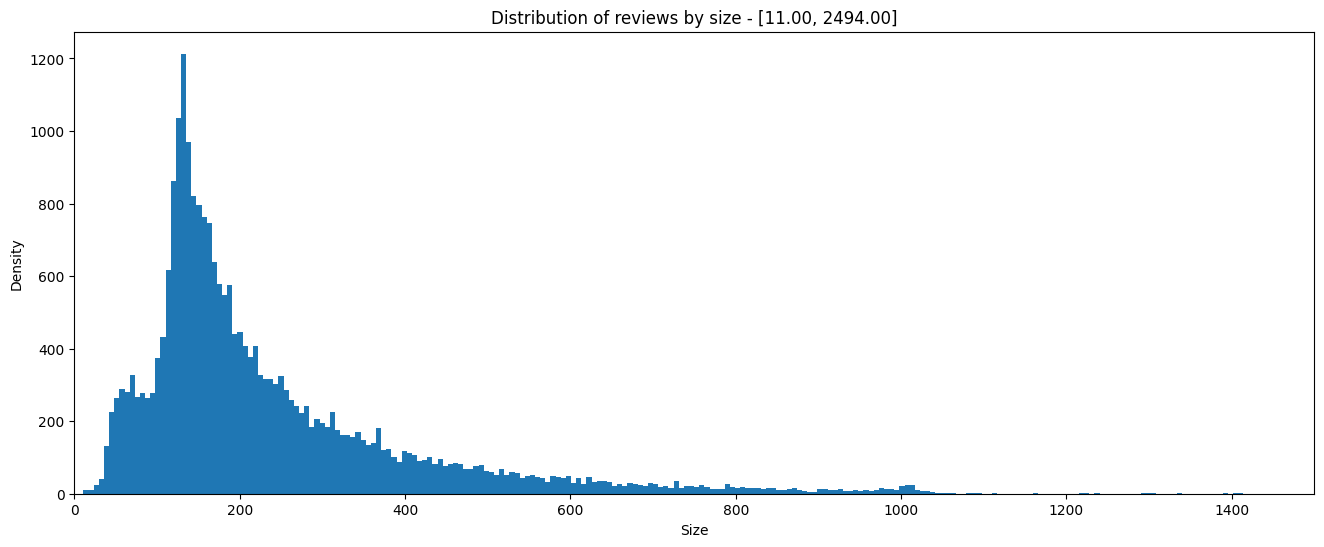

In [87]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)),
              xlabel='Size', ylabel='Density', xlim=[0,1500])
plt.show()

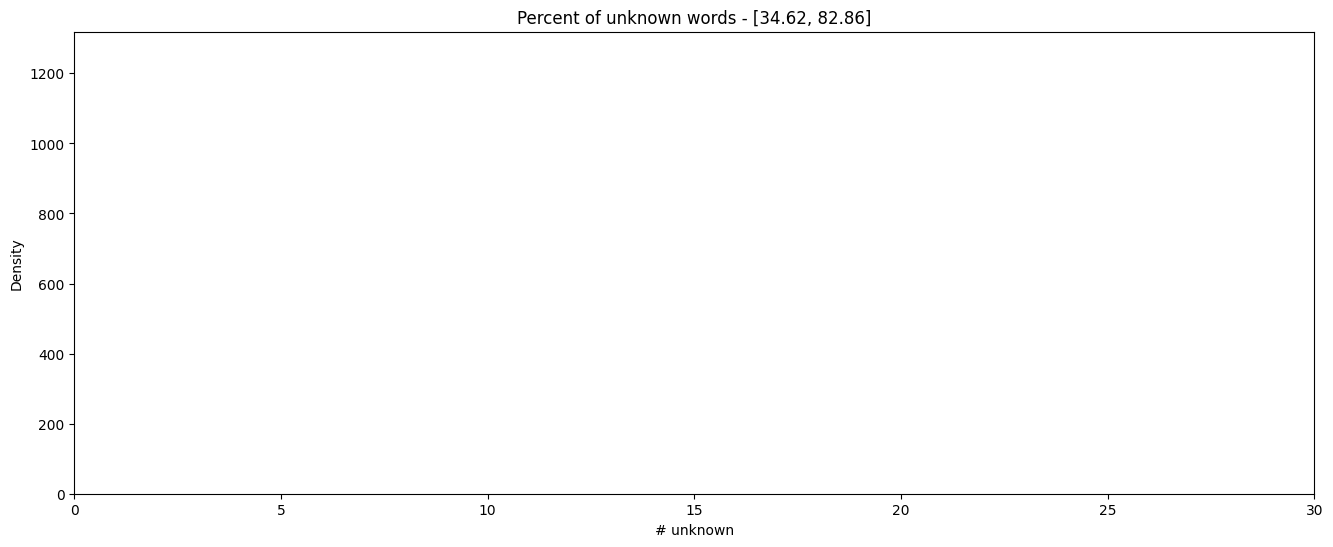

In [88]:
unk=[ 100*(s.count(2)/len(s)) for s in x_train]
plt.figure(figsize=(16,6))
plt.hist(unk, bins=100)
plt.gca().set(title='Percent of unknown words - [{:5.2f}, {:5.2f}]'.format(min(unk),max(unk)),
              xlabel='# unknown', ylabel='Density', xlim=[0,30])
plt.show()

## Step 5 - Basic approach with "one-hot" vector encoding

Each sentence is encoded with a **vector** of length equal to the **size of the dictionary**.   

Each sentence will therefore be encoded with a simple vector.  
The value of each component is 0 if the word is not present in the sentence or 1 if the word is present.

For a sentence s=[3,4,7] and a dictionary of 10 words...    
We wil have a vector v=[0,0,0,1,1,0,0,1,0,0,0]

### 5.1 - Our one-hot encoder

In [89]:
def one_hot_encoder(x, vector_size=10000):

    # ---- Set all to 0
    #
    x_encoded = np.zeros((len(x), vector_size))

    # ---- For each sentence
    #
    for i,sentence in enumerate(x):
        for word in sentence:
            x_encoded[i, word] = 1.

    return x_encoded

### 5.2 - Encoding

In [90]:
x_train_one_hot = one_hot_encoder(x_train, vector_size=vocab_size)
x_test_one_hot  = one_hot_encoder(x_test,  vector_size=vocab_size)

print("To have a look, x_train[12] became :", x_train_one_hot[12] )

To have a look, x_train[12] became : [0. 0. 1. ... 0. 0. 0.]


## Step 6 - Build the model

In [91]:
def get_model(vector_size=10000):

    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(vector_size,) ))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 32, activation='relu'))
    model.add(keras.layers.Dense( 1, activation='sigmoid'))

    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 7 - Train the model
### 7.1 - Get it

In [92]:
model = get_model(vector_size=vocab_size)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                160032    
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 161121 (629.38 KB)
Trainable params: 161121 (629.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 7.2 - Add callback

In [93]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_one_hot.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 7.3 - Train it

In [94]:
%%time

history = model.fit(x_train_one_hot,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_one_hot, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])


Epoch 1/10
49/49 [==============================] - 4s 68ms/step - loss: 0.4509 - accuracy: 0.8205 - val_loss: 0.3267 - val_accuracy: 0.8769
Epoch 2/10
 7/49 [===>..........................] - ETA: 0s - loss: 0.2651 - accuracy: 0.9121

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 2s 31ms/step - loss: 0.2726 - accuracy: 0.8967 - val_loss: 0.2953 - val_accuracy: 0.8799
Epoch 3/10
49/49 [==============================] - 1s 29ms/step - loss: 0.2287 - accuracy: 0.9132 - val_loss: 0.3021 - val_accuracy: 0.8760
Epoch 4/10
49/49 [==============================] - 2s 49ms/step - loss: 0.2074 - accuracy: 0.9226 - val_loss: 0.3222 - val_accuracy: 0.8708
Epoch 5/10
49/49 [==============================] - 2s 42ms/step - loss: 0.1876 - accuracy: 0.9296 - val_loss: 0.3390 - val_accuracy: 0.8678
Epoch 6/10
49/49 [==============================] - 2s 33ms/step - loss: 0.1718 - accuracy: 0.9345 - val_loss: 0.3621 - val_accuracy: 0.8640
Epoch 7/10
49/49 [==============================] - 2s 33ms/step - loss: 0.1551 - accuracy: 0.9437 - val_loss: 0.3762 - val_accuracy: 0.8640
Epoch 8/10
49/49 [==============================] - 2s 33ms/step - loss: 0.1380 - accuracy: 0.9509 - val_loss: 0.4078 - val_accuracy: 0.8584
Epoch 9/10
49/49 [======

## Step 8 - Evaluate
### 8.1 - Training history

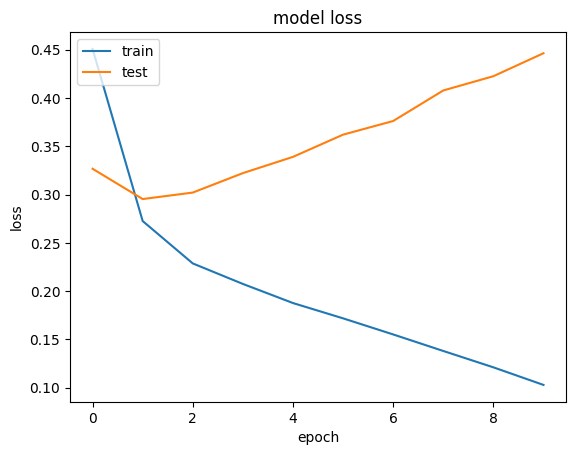

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

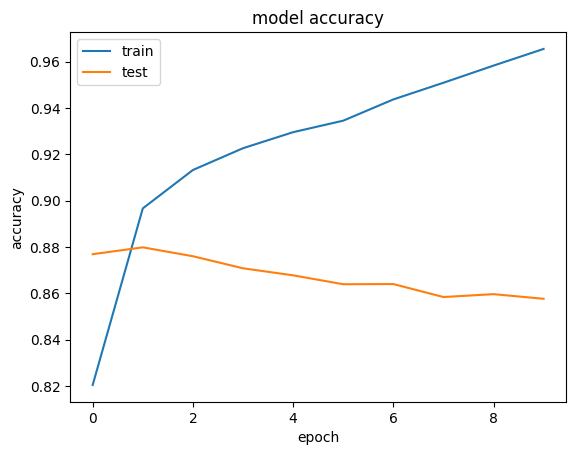

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 8.2 - Reload and evaluate best model

In [97]:
model = keras.models.load_model(f'{run_dir}/models/best_model_one_hot.h5')

# ---- Evaluate
score  = model.evaluate(x_test_one_hot, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_one_hot)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1

confusion_matrix(y_test, y_pred, labels=range(2))

x_test / loss      : 0.2953
x_test / accuracy  : 0.8799
782/782 [==============================] - 2s 3ms/step


array([[10914,  1586],
       [ 1417, 11083]])

## Questions

1. What are the drawbacks of this encoding approach?
2. Does the model seem to overfit/underfit the data? On which hyperparameter(s) can you act to resolve this?

1. One-Hot Encoding has a lot of weaknesses. Semantic information, such as the similarity of the meanings of words is not taken into account. Neither is the position of the words in the sentence. All of this could be ameliorated by embedding representations of the words into a multidimensional space.

2. The model severely overfits the data. Perhaps changing the vocab_size or the hide_most_frequently hyperparameters could have an effect. I tested a number of values but I could not get the validation accuracy to increase significantly.

# **Part 2: Word embeddings**

## Step 1 - Preprocess the data

### 1.1 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.  
`review_len` is the review length  
`dense_vector_size` is the size of the generated dense vectors  
`output_dir` is where we will go to save our dictionaries. (./data is a good choice)\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [150]:
review_len           = 256
dense_vector_size    = 12

epochs               = 30
batch_size           = 512

output_dir           = './data'
fit_verbosity        = 1

### 1.2 - Padding

In order to be processed by an embedding neural network, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [151]:
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test_pad  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

# fidle.utils.subtitle('After padding :')
print(f'After padding: {x_train_pad[12]}')

After padding: [   2    2  119  954  189 1554    2    2  459    2    2  116    2 1492
 2291    2  726    2 1939  168 2031    2  423    2    2  549    2    2
    2  547    2    2    2    2    2  454    2    2    2    2    2    2
  130  168    2    2  359    2  158 1511    2    2    2 1913    2  194
 4455 4121    2  114    2    2    2  465    2  304    2    2    2    2
    2    2  155    2    2  226  162  616  651    2    2    2    2    2
    2    2    2  218 4843  629    2 3017    2    2    2    2    2  534
    2    2  320    2  516    2    2    2  181    2  130    2  547 3571
    2 1471  851    2 2286    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  

## Step 2 - Build the model

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [152]:
def get_model(vocab_size=10000, dense_vector_size=32, review_len=256):

    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(review_len,) ))
    model.add(keras.layers.Embedding(input_dim    = vocab_size,
                                     output_dim   = dense_vector_size,
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 3 - Train the model
### 3.1 - Get it

In [153]:
model = get_model(vocab_size, dense_vector_size, review_len)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 256, 12)           60000     
                                                                 
 global_average_pooling1d_6  (None, 12)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_33 (Dense)            (None, 12)                156       
                                                                 
 dense_34 (Dense)            (None, 1)                 13        
                                                                 
Total params: 60169 (235.04 KB)
Trainable params: 60169 (235.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2 - Add callback

In [154]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_embeddings.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 3.3 - Train it

In [155]:
%%time

history = model.fit(x_train_pad,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_pad, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])


Epoch 1/30
49/49 [==============================] - 3s 37ms/step - loss: 0.6919 - accuracy: 0.5170 - val_loss: 0.6898 - val_accuracy: 0.5550
Epoch 2/30
 5/49 [==>...........................] - ETA: 1s - loss: 0.6894 - accuracy: 0.6574

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 2s 45ms/step - loss: 0.6849 - accuracy: 0.6912 - val_loss: 0.6783 - val_accuracy: 0.7771
Epoch 3/30
49/49 [==============================] - 1s 24ms/step - loss: 0.6659 - accuracy: 0.7880 - val_loss: 0.6531 - val_accuracy: 0.8179
Epoch 4/30
49/49 [==============================] - 2s 38ms/step - loss: 0.6305 - accuracy: 0.8284 - val_loss: 0.6122 - val_accuracy: 0.8267
Epoch 5/30
49/49 [==============================] - 2s 38ms/step - loss: 0.5797 - accuracy: 0.8376 - val_loss: 0.5596 - val_accuracy: 0.8280
Epoch 6/30
49/49 [==============================] - 1s 27ms/step - loss: 0.5210 - accuracy: 0.8463 - val_loss: 0.5054 - val_accuracy: 0.8376
Epoch 7/30
49/49 [==============================] - 1s 30ms/step - loss: 0.4654 - accuracy: 0.8544 - val_loss: 0.4583 - val_accuracy: 0.8436
Epoch 8/30
49/49 [==============================] - 1s 29ms/step - loss: 0.4195 - accuracy: 0.8574 - val_loss: 0.4220 - val_accuracy: 0.8484
Epoch 9/30
49/49 [======

## Step 4 - Evaluate
### 4.1 - Training history

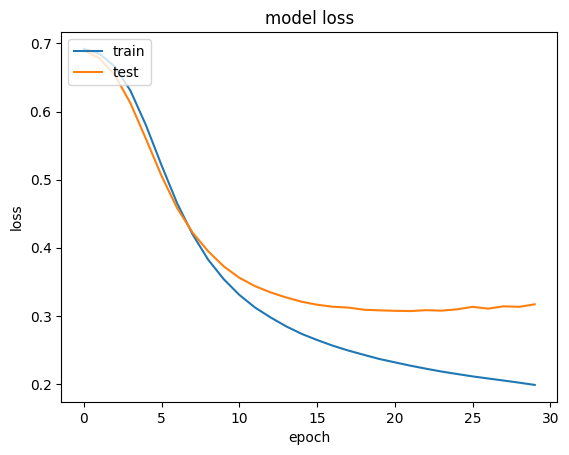

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

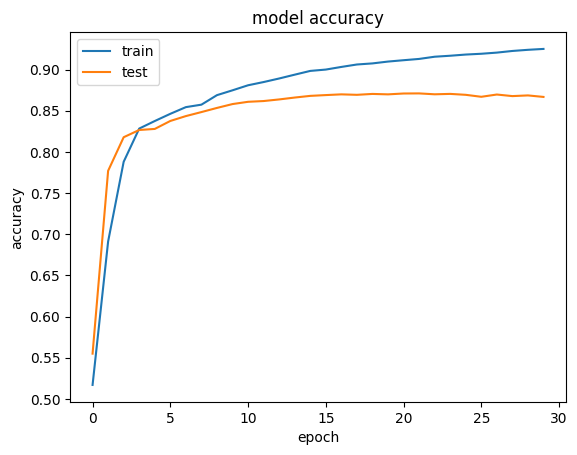

In [157]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.2 - Reload and evaluate best model

In [158]:
model = keras.models.load_model(f'{run_dir}/models/best_model_embeddings.h5')

# ---- Evaluate
score  = model.evaluate(x_test_pad, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_pad)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1

confusion_matrix(y_test, y_pred, labels=range(2))

x_test / loss      : 0.3070
x_test / accuracy  : 0.8711
782/782 [==============================] - 2s 2ms/step


array([[10788,  1712],
       [ 1510, 10990]])

## Questions

1. Compare empirically this model to the one of the previous part (with one-hot encoded features): which one is best in terms of performance, memory and runtime? Which one would you choose and why?
2. What are the theoretical advantages and disadvantages of each approach (in terms of performance, computation, interpretability...)?
3. Change the dimension of the embedding space. How does it influence performance? How would you choose this dimension?

1-2. The second model with embeddings performs much more accurately. Its test accuracy maxes out at around the 8th epoch, and its total training time and total size in memory is not much different from the first model. I would say that it is a much better model in every respect.

3. I increased and decreased the size of the embedding space and found that the test accuracy remained around 85% in both cases, and in the case of a very large embedding size, the accuracy started to drop off towards the later epochs. Thus, since the performance is basically the same, I would opt for a lower embedding size to keep my model small and fast.

## Step 5 - Have a look at the embeddings
### 5.1 Retrieve embeddings

In [159]:
embeddings = model.layers[0].get_weights()[0]
print('Shape of embeddings : ',embeddings.shape)

Shape of embeddings :  (5000, 12)


### 5.2 - Build a nice dictionary

In [160]:
word_embedding = { index_word[i]:embeddings[i] for i in range(vocab_size) }

### 5.3 Show embedding of a word :

In [161]:
word_embedding['nice']

array([ 0.4172741 ,  0.36550853, -0.3333928 , -0.44276634,  0.33877635,
       -0.39784518, -0.45264608, -0.3448552 ,  0.33789277,  0.39420676,
        0.41257018,  0.40330994], dtype=float32)

#### Few usefull functions to play with

In [162]:
# Return a l2 distance between 2 words
#
def l2w(w1,w2):
    v1=word_embedding[w1]
    v2=word_embedding[w2]
    return np.linalg.norm(v2-v1)

# Show distance between 2 words
#
def show_l2(w1,w2):
    print(f'\nL2 between [{w1}] and [{w2}] : ',l2w(w1,w2))

# Displays the 15 closest words to a given word
#
def neighbors(w1):
    v1=word_embedding[w1]
    dd={}
    for i in range(4, 1000):
        w2=index_word[i]
        dd[w2]=l2w(w1,w2)
    dd= {k: v for k, v in sorted(dd.items(), key=lambda item: item[1])}
    print(f'\nNeighbors of [{w1}] : ', list(dd.keys())[1:15])


### 5.4 Examples

In [163]:
show_l2('nice', 'pleasant')
show_l2('nice', 'horrible')

neighbors('horrible')
neighbors('great')



L2 between [nice] and [pleasant] :  0.6141109

L2 between [nice] and [horrible] :  4.5742803

Neighbors of [horrible] :  ['fails', 'badly', 'annoying', 'avoid', 'ridiculous', 'dull', 'poor', 'worse', 'mess', 'terrible', 'save', 'boring', 'lame', 'predictable']

Neighbors of [great] :  ['he', 'br', 'bad', 'story', 'the', 'much', 'then', 'have', 'on', 'about', 'this', 'with', 'so', 'you']


## Question

1. Is this method designed to force the embeddings to have semantic meaning?
2. Give a visualization of the word embeddings by doing a PCA on the embedding matrix. Plot some of the words the space of the first two Principal Components.
3. Give some interpretation on the PCs of these embeddings.

1. Well, it's not so much that the method forces the embeddings to have semantic meaning, but rather that words that have a similar semantic meaning tend to occupy similar positions and contexts within text, so these semantic connections arise somewhat naturally. However, as you can see with the word "great", the words closest to it are not necessarily semantically related.

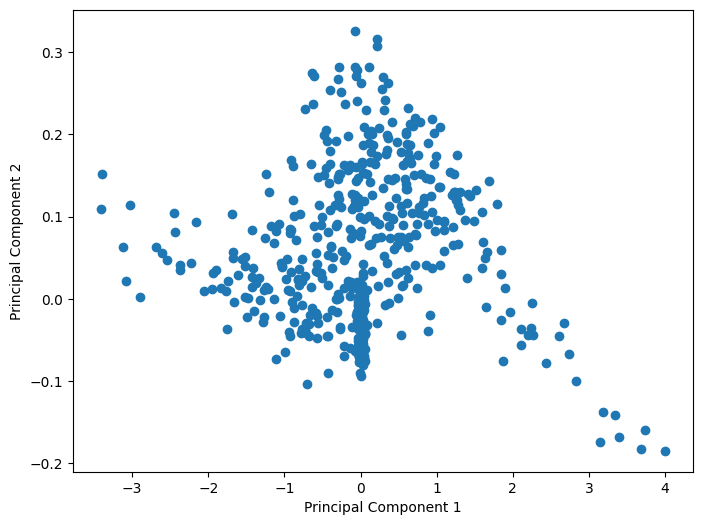

In [175]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
P = pca.fit_transform(embeddings)
P = P[:500,:]

plt.figure(figsize=(8, 6))
plt.scatter(P[:, 0], P[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()


In [183]:
extreme_indices = [
    np.argmin(P[:, 0]),
    np.argmax(P[:, 0]),
    np.argmin(P[:, 1]),
    np.argmin(P[:, 1]),
]

extreme_embeddings = pca.inverse_transform(P[extreme_indices])

extreme_words = []

for embedding in extreme_embeddings:
  for key, value in word_embedding.items():
    if np.array_equal(embedding, value):
      print("here")
      extreme_words.append(key)

print(extreme_words)


4
[[ 0.98832923  1.0092074  -0.9304239  -1.076319    0.9752848  -0.98093826
  -1.0235671  -0.97906274  0.9404372   1.0024213   0.9573318   0.9635123 ]
 [-1.1530479  -1.1690933   1.0859544   1.2148637  -1.1537794   1.1465814
   1.1721566   1.2013954  -1.0950991  -1.1683583  -1.1296962  -1.1286823 ]
 [-1.1530479  -1.1690933   1.0859544   1.2148637  -1.1537794   1.1465814
   1.1721566   1.2013954  -1.0950991  -1.1683583  -1.1296962  -1.1286823 ]
 [-1.1530479  -1.1690933   1.0859544   1.2148637  -1.1537794   1.1465814
   1.1721566   1.2013954  -1.0950991  -1.1683583  -1.1296962  -1.1286823 ]]
[]


3. There is a concentration along the vertical axis, particularly between 0 and 1. I would imagine that these are the semantically empty words like "a", "and", "so", etc. Then the graph branches out into three dimensions, up, left and down-right. I tried to recover the words which make up the most extreme points on the graph but was not able to. However, this may have given us an idea of what the principal components might represent.

# Part 3: Train a GRU

## Step 1 : Parameters

In [184]:
epochs               = 10
batch_size           = 128

## Step 2 : Build the model

In [185]:
def get_model(dense_vector_size=128):

    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim = vocab_size, output_dim = dense_vector_size))
    model.add(keras.layers.GRU(50))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 3 - Train the model
### 3.1 - Get it

In [186]:
model = get_model(32)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          160000    
                                                                 
 gru (GRU)                   (None, 50)                12600     
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 172651 (674.42 KB)
Trainable params: 172651 (674.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2 - Add callback

In [187]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model_gru.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 3.3 - Train it

In [ ]:
%%time

history = model.fit(x_train_pad,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test_pad, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])


Epoch 1/10
196/196 [==============================] - 60s 295ms/step - loss: 0.6929 - accuracy: 0.5020 - val_loss: 0.6929 - val_accuracy: 0.5013
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5279

## Step 4 - Evaluate
### 4.1 - Training history

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.2 - Reload and evaluate best model

In [ ]:
model = keras.models.load_model(f'{run_dir}/models/best_model_gru.h5')

# ---- Evaluate
score  = model.evaluate(x_test_pad, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]

# ---- Confusion matrix

y_sigmoid = model.predict(x_test_pad)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1

confusion_matrix(y_test, y_pred, labels=range(2))

## Questions

1. What is the main advantage of this model compared to the previous ones?
2. Compare empirically the performance of the 3 models. Which one would you choose and why?
3. Change the model to use one-hot encoding instead of word embeddings, but keeping a GRU layer. Train it and compare the performance.
4. Play with other recurrent architectures, as described in the [Documentation](https://keras.io/api/layers/recurrent_layers/) and compare their performance. In particular you can compare a bi-directional GRU to a simple GRU, and also use a Long-Short Term Memory Network (LSTM).